---
layout: page
title: Testes de Hipóteses
nav_order: 20
---
[<img src="https://raw.githubusercontent.com/flaviovdf/fcd/master/assets/colab_favicon_small.png" style="float: right;">](https://colab.research.google.com/github/flaviovdf/fcd/blob/master/_lessons/20-TestesDeHipoteses.ipynb)

# Tópico 20 – Testes de Hipóteses
{: .no_toc .mb-2 }

Após aprendermos sobre a importância da distribuição Normal no processo de inferência para diversos tipos de problemas, voltamos nossa atenção para um tópico fundamental em Ciência de Dados: "como testar se um conjunto de hipóteses feitas sobre os dados é adequado ou não?". Para responder essa pergunta, introduziremos a noção de modelos estatísticos e um conjunto de métodos desenhado especificamente para verificar a utilidade desses modelos na prática, denominados de Testes de Hipóteses.
{: .fs-6 .fw-300 }

{: .no_toc .text-delta }
Resultados Esperados 

1. Aprender a definir o que são modelos estatísticos, e a formular problemas práticos em Ciência de Dados como modelos.
1. Introduzir o conceito de significância estatística, e a caracterização da "quantidade de erro aleatório" que estamos dispostos a permitir em situações práticas.
1. Introduzir as noções básicas de Testes de Hipóteses, e a utilizar essa metodologia para testar a adequação de diferentes modelos estatísticos em problemas de análises de dados.

{: .no_toc .text-delta }
Material Adaptado do [DSC10 (UCSD)](https://dsc10.com/)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as scipy
plt.style.use('ggplot')

np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option("display.max_rows", 7)
pd.set_option("display.max_columns", 8)
pd.set_option("display.precision", 2)

## Modelos Estatísticos

### Modelos

- Informalmente, um **modelo estatístico** consiste de um conjunto de hipóteses sobre o qual fazemos sobre o processo que gerou nossos dados.
- Exemplos simples de modelos são:
    - Moedas "justas" têm probabilidade igual (50%) de cara e coroa.
    - Dados "justos" têm probabilidade igual (1/6) para cada um dos lados.
    - A gravidez de uma fêmea Golden Retriever pode resultar em 1 até 14 (!) filhotes, com média entre 7 e 8.

- Um dos principais objetivos em Inferência Estatística é **aferir a qualidade de um modelo**.
    - Em outras palavras, buscamos aferir o **quão bem um modelo explica a "realidade"** refletida nos dados.  

- Conforme aprendemos até agora, a maioria dos problemas em Inferência pode ser resolvido através de alguma teoria (baseada em Matemática e Probabilidade) e também com técnicas de simulação.

- Em ambos os casos, vamos sempre **assumir que o nosso modelo seja verdadeiro**, e então calcular as frequências/probabilidades com as quais os padrões observados nos nossos dados ocorreriam sob esse modelo. 

- Em geral, o processo de verificar se um modelo é adequado ou não para um certo conjunto de dados é denominado de **teste de hipótese**. Definiremos essa noção mais formalmente abaixo.

### Exemplo: lançamento de uma moeda

Suponha que você queira decidir se uma certa moeda é "justa", isto é, se no lançamento dessa moeda a probabilidade de uma cara é igual a probabilidade de uma coroa (isto é, 1/2 ou 50%).

Para verificar isso, você lança a moeda $n = 400$ vezes, anotando os resultados obtidos.

In [2]:
flips_400 = pd.read_csv('https://raw.githubusercontent.com/flaviovdf/fcd/master/assets/19-Hipoteses/data/flips-400.csv')
flips_400

,flip,outcome
0,1,Tails
1,2,Tails
2,3,Tails
...,...,...
397,398,Heads
398,399,Heads
399,400,Tails


In [3]:
flips_400.groupby('outcome').count()

,flip
outcome,
Heads,188
Tails,212


- Naturalmente, surge então a seguinte pergunta: **esse resultado é consistente ou não** com o nosso "modelo", isto é, com a _hipótese_ de que a moeda é justa?
    - Em outras palavras, quão _provável_ (ou improvável) seria obtermos 188 caras em 400 lançamentos de uma moeda justa?

## Significância Estatística

- Antes de introduzirmos o ferramental necessário para responder à pergunta acima, primeiramente vamos refletir um pouco sobre a seguinte pergunta:

> Se esperamos _exatamente_ uma proporção de 50% de caras nos lançamentos da moeda do exemplo anterior, quais as proporções $p$ de caras aceitaríamos como **estatisticamente iguais** a 50%? O que nesse caso seria uma "diferença inaceitável" entre $p$ e 50% para decidirmos que a moeda não é justa?  

- Para responder perguntas como essa, frequentemente utilizamos o conceito de **significância estatística**. 

- Basicamente, um resultado é considerado **estatisticamente significante** se sua ocorrência por pura chance/aleatoriedade/"coincidência" é considerada **baixa**.
- Mais formalmente, um evento é considerado estatisticamente significante se sua probabilidade é **menor** do que um certo valor $\alpha \in (0, 1)$.
    - Denominamos $\alpha$ então de **nível de significância**. Um nível de significância muito comum utilizado na prática é $\alpha = 5\%$.

- O _complementar_ do nível de significância $\alpha$ é o nível de confiança $\gamma$ que vimos anteriormente, isto é, $\alpha + \gamma = 1$.
    - Escolher um nível de significância de $\alpha = 5\%$ é então equivalente a escolher um nível de confiança de $\gamma = 1 - \alpha = 95\%$.

### De volta ao exemplo da moeda

- _Supondo que a moeda seja justa_, qual a probabilidade de ocorrerem entre 188 e 212 caras em $n = 400$ lançamentos?

- Omitindo as tecnicalidades, essa probabilidade é dada por (lembre do Triângulo de Pascal!)

\begin{equation*}
    \sum^{212}_{k = 188} {n \choose k} \left(\frac{1}{2}\right)^k \left(\frac{1}{2}\right)^{n-k} \simeq 0.7693,
\end{equation*}

ou 76.93%.

- No Python, podemos calcular essa probabilidade através da função de distribuição acumulada da _Distribuição Binomial_, `scipy.stats.binom.cdf`.
    - Essa é outra distribuição que você verá nos próximos cursos!
    - Os parâmetros dessa função são `x` $(x \in \mathbb{R})$, o número de experimentos `n` $(n \in \mathbb{N})$ e a probabilidade de sucesso de cada experimento, `p` $(0 < p < 1)$.
    - Como toda função de distribuição acumulada, para calcular a probabilidade dos valores no intervalo $[a, b]$, fazemos $F(b) - F(a)$.

In [4]:
scipy.stats.binom.cdf(212, 400, .5) - scipy.stats.binom.cdf(188, 400, .5)

0.7693207085127098

- Dessa forma, _se a moeda for justa_, a probabilidade de obtermos um número de caras entre 188 e 212 é bem alta!
- Analogamente, a probabilidade de obtermos um número de caras **menor** que 188 e **maior** que 212 será então igual a $1 - 0.7639 \simeq 0.2307$

In [5]:
1 - (scipy.stats.binom.cdf(212, 400, .5) - scipy.stats.binom.cdf(188, 400, .5))

0.23067929148729016

- O resultado acima nos diz então que, ainda que a moeda seja justa, em $n = 400$ lançamentos a probabilidade de obtermos algo em torno de 188 a 212 caras é bem razoável.
- Em outras palavras, como $188/400 = 0.47$ e $212/400 = 0.53$, desvios de até $3\%$ no número esperado de caras ($50\%$) em $n = 400$ lançamentos de uma moeda ocorrem com uma probabilidade de $23.07\%$.

- Dessa forma, uma ocorrência de 188 caras em 400 lançamentos **não é considerada significativa** a um nível $\alpha = 5\%$!

- O que seria então considerado estatisticamente significante nesse problema? 🤔

In [6]:
heads = 181
1 - (scipy.stats.binom.cdf(400 - heads, 400, .5) - scipy.stats.binom.cdf(heads, 400, .5))

0.05760952246249662

In [7]:
heads = 180
1 - (scipy.stats.binom.cdf(400 - heads, 400, .5) - scipy.stats.binom.cdf(heads, 400, .5))

0.04563548140489304

- Se tomarmos um nível de significância de $\alpha = 5\%$, observar de 181 a 219 caras (desvios de até 4.75%) ainda seria considerado "aceitável" (i.e. não-significante) nesse caso.
- Precisaríamos de um resultado mais extremo (e desvios maiores, maiores ou iguais 5%) para ser considerado estatisticamente significante, como por exemplo 180 caras ou menos, ou 220 caras ou mais. 

> Para concluir nosso exemplo (e mais uma vez note que vamos voltar a esse ponto mais adiante), lembrando da complementariedade entre o nível de confiança $\gamma$ e o nível de significância $\alpha$, podemos obter a _mesma resposta acima_ através de um intervalo de 95% de confiança para a proporção populacional de caras em uma moeda justa, que podemos calcular através de:

In [8]:
scipy.stats.binom.interval(0.95, 400, .5)

(180.0, 220.0)

## Testes de Hipóteses

### Noções básicas

- Podemos definir um **Teste de Hipóteses** como um procedimento em que testamos a **hipótese de que o nosso modelo esteja correto** contra a **hipótese de que o nosso modelo não esteja correto**.
    - A primeira hipótese, isto é, de que o nosso modelo esteja correto é denominada de **hipótese nula**.
    - A segunda hipótese, isto é, de que o nosso modelo não esteja correto é denominada de **hipótese alternativa**.
- A **aceitação** de uma hipótese em detrimento da outra leva à **rejeição** da outra hipótese.

- **Muito importante:** Embora estejamos definindo os Testes de Hipóteses e nossos modelos em termos como "aceitação" e "correto", note que na verdade o procedimento apenas nos diz se o modelo postulado é _condizente_ com os padrões observados nos nossos dados.
    - Dessa forma, como em geral o processo gerador dos dados é _aleatório_, podemos aceitar a hipótese de um modelo esteja correto (ou errado) por _pura aleatoriedade_, sem que na verdade o modelo seja _verdadeiramente_ correto (ou errado)!

- Em vista da observação acima, uma outra maneira de pensarmos no nível de significância é como um **nível máximo permitido** para a influência da incerteza/aleatoriedade sobre o nosso experimento/processo gerador de dados.
    - Equivalentemente, $\alpha$ representa **a frequência máxima com a qual nosso modelo (ainda que esteja correto) possa ser rejeitado por um teste de hipóteses**.

> No exemplo acima, embora 400 lançamentos de uma moeda justa possam _de fato_ produzir menos de 180 caras (ou mais de 220), a _probabilidade_ com a qual isso ocorre é menor que $\alpha$.
> > Reiterando sobre esse ponto, _ainda que nosso modelo esteja correto_, a probabilidade desse resultado ocorrer por pura aleatoriedade é _tão baixa_ que consideramos que é mais _plausível_ que nosso modelo esteja errado! 

- Finalmente, como para cada hipótese nula fazemos um teste separado, é possível que **aceitemos várias hipóteses nulas diferentes** e, logo, **vários modelos diferentes**, para os mesmos dados.
    - Embora existam algumas maneiras de contornar esse problema (você verá isso nos próximos cursos!), essa é uma característica **inerente** não somente aos Testes de Hipóteses, mas à Inferência Estatística como um todo.
    - Lembre da nossa discussão anterior sobre **igualdade estatística**: com 95% de confiança, todas as proporções $p \in (0.45, 0.55)$ são _igualmente prováveis_ (inclusive $p = 0.50$!) nesse experimento.

### Hipóteses nulas e alternativas

- Vamos agora formalizar as noções de hipóteses dadas acima.

- No exemplo da moeda justa, nossa hipótese nula é
    - "a moeda é justa".
- Analogamente, nossa hipótese alternativa é
    - "a moeda não é justa".

- Em um teste de hipóteses, a hipótese nula deve ser um **modelo de probabilidade bem definido** sobre o processo que gerou nossos dados.
    - Precisamos disso para poder calcular todas as probabilidades e frequências sobre as quais estamos interessados, não só do ponto de vista _teórico/matemático_ como também do ponto de vista _prático/computacional_.
    - Em outras palavras: precisamos definir bem um modelo para simular desse modelo!
    - Usualmente denotamos a hipótese nula por $H_0$.

- Mais uma vez voltando ao nosso exemplo, uma possível hipótese nula aqui seria $H_0: p_0 = 0.5$, onde $p_0$ representa a probabilidade do lançamento de uma moeda resultar em cara.
    - Tecnicamente, para que esse modelo esteja realmente bem definido definimos uma variável aleatória tomando valores no espaço amostral $\{H, T\}$ com probabilidades $p_0$ e $1 - p_0$, respectivamente.

- Por outro lado, a **hipótese alternativa** representa uma _visão diferente_ (e usualmente complementar, para que o **teste** esteja bem definido) do processo que gerou nossos dados.
    - Dessa forma, a hipótese alternativa **não precisa ser específica**, uma vez que basta a hipótese nula _ser rejeitada_ para que a hipótese alternativa seja aceita.
    - Usualmente denotamos a hipótese alternativa por $H_1$. 

- Retornando ao exemplo da moeda, uma possível hipótese alternativa seria $H_1:p_0 \neq 0.5$.
    - Note que essa é uma hipótese bem vaga, assim como "a moeda não é justa", pois _qualquer valor_ para a proporção de caras diferente de $0.5$ satisfaz a hipótese alternativa.

### Estatísticas de teste

- Uma vez definidas $H_0$ e $H_1$, começamos nossa inferência **supondo que a hipótese nula $H_0$ seja verdadeira**.

- **Sob $H_0$**, calcularemos então uma quantidade que denominaremos de **estatística de teste** (usualmente denotada por $T$).
    - Como o próprio nome implica, essa será uma **estatística** (e logo calculada com base na amostra) utilizada para realizarmos nosso teste.
    - Em essência, a estatística de teste objetiva medir a evidência _a favor_ (ou _contra_) $H_0$. 

- Se utilizarmos a teoria Estatística/matemática para conduzir nosso teste de hipótese, calculamos _uma única estatística de teste_ sob $H_0$, e essencialmente utilizamos a teoria para saber se o **valor observado** (usualmente denotado por $T_{obs}$) é _estatisticamente significante_.
    - Por exemplo, sob o TCL, sabemos que 95% dos valores de uma distribuição Normal estão a ± 2 DPs da média. Dessa forma, se sob $H_0$ temos $\mu = 10$ e $\sigma/\sqrt{n} = 1$, um valor para $T_{obs} = \bar{X}$ menor que 8 e maior que 12 seria considerado estatisticamente significante sob $\alpha = 5\%$. 

- Por outro lado, se utilizarmos simulação, teremos _uma estatística de teste para cada amostra_ produzida sob $H_0$.
    - Com um número grande de amostras, produzimos então uma aproximação para a distribuição de probabilidade da estatística de teste $T$, e verificamos se o valor observado $T_{obs}$ é estatisticamente significante nessa distribuição.
    - A verificação de significância nesse caso consiste essencialmente em verificar à _qual percentil dessa distribuição_ corresponde o valor de $T_{obs}$.

### Simulando sob $H_0$

- Voltando ao nosso exemplo anterior, podemos simular `n` lançamentos de uma moeda justa utilizando a função `np.random.binomial(n, 0.5)`.
    - Lembre que aqui simulamos sob $H_0$, e simular sob $H_1$ seria impossível (existem infinitos não-enumeráveis valores de $p_0$ que satisfazem a definição de "moeda injusta").

- Como estamos interessados na proporção de caras, nossa estatística de teste $T$ será o número de caras em cada simulação.
    - Calculamos então $T_{obs}$ para cada amostra produzida, anotamos o valor correspondente e dessa forma construímos uma distribuição empírica para a estatística de teste $T$ sob $H_0$.

In [9]:
# Computes a single simulated test statistic.
np.random.binomial(400, 0.5)

202

In [10]:
# Computes 10,000 simulated test statistics.
np.random.seed(42)

results = np.array([])
for i in np.arange(10000):
    result = np.random.binomial(400, 0.5)
    results = np.append(results, result)
    
results

array([193., 194., 202., ..., 201., 201., 192.])

### Distribuição empírica da estatística de teste

Vamos agora visualizar a distribuição empírica da estatística de teste sob $H_0$:

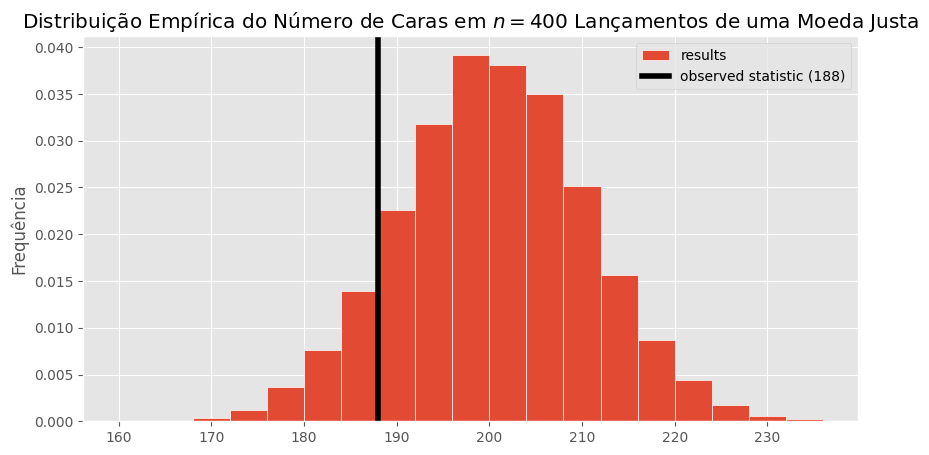

In [11]:
pd.DataFrame().assign(results=results).plot(kind='hist', bins=np.arange(160, 240, 4), 
                                             density=True, ec='w', figsize=(10, 5),
                                             title='Distribuição Empírica do Número de Caras em $n = 400$ Lançamentos de uma Moeda Justa');
plt.axvline(188, color='black', linewidth=4, label='observed statistic (188)')
plt.legend()
plt.ylabel("Frequência");

- Se observássemos $T_{obs} = 200$ caras, naturalmente aceitaríamos $H_0$, isto é, que nossa moeda é justa.

- Analogamente, rejeitaríamos $H_0$ (isto é, concluiríamos que nossa moeda é injusta) se:
    - observássemos "poucas caras".
    - observássemos "muitas caras".

- Mas como decidimos o que seriam "poucas" e "muitas" nesse contexto?

### Valores Críticos e Regiões de Aceitação

- Dada a nossa discussão acima sob significância estatística, seria natural **rejeitarmos $H_0$ se a probabilidade de observarmos $T_{obs}$ for muito baixa**.

- No exemplo anterior, vimos (teoricamente) que a probabilidade de que $T \leq 180$ ou que $T \geq 220$ é pouco menos que 5%.
    - Dessa forma, valores **tão extremos** quanto $T \leq 180$ ou $T \geq 220$ são considerados **estatisticamente significantes** (ao nível de $\alpha = 5\%$), e logo indicativos de que $H_0$ não é verdadeira.

- Na distribuição simulada anteriormente, podemos encontrar esses valores como os percentis 2.5% e 97.5%, respectivamente.

In [12]:
np.percentile(results, 2.5)

180.0

In [13]:
np.percentile(results, 97.5)

220.0

- Ao nível de $\alpha = 5\%$ de significância, dizemos que $c_1 = 180$ e $c_2 = 220$ são então os **níveis críticos** (ou valores críticos) desse teste de hipóteses.

- Mais formalmente, os **níveis críticos** de um teste são valores $c_1 < c_2$ tais que **$H_0$ é rejeitada ao nível $\alpha\%$ de significância** caso $T_{obs} < c_1$ _ou_ $T_{obs} > c_2$.
    - Note que formalmente sempre frisamos "ao nível $\alpha\%$ de significância", pois os níveis críticos $c_1$ e $c_2$ sempre serão funções de $\alpha$.

- Quando simulamos a distribuição de $T$ sob $H_0$, $c_1$ e $c_2$ são simplesmente dados pelos percentis $\alpha/2$ e $1 - \alpha/2$ dessa distribuição, respectivamente.
    - Analogamente, se utilizarmos alguma teoria ou aproximação (por exemplo o TCL), $c_1$ e $c_2$ serão dados pelos percentis correspondentes da distribuição correspondente (por exemplo a Normal).

- Na nomenclatura usual de Testes de Hipóteses, o conjunto de pontos entre $c_1$ e $c_2$ definem a **Região de Aceitação** do teste.
    - Formalmente, $RA := \{T_{obs}: c_1 \leq T_{obs} \leq c_2\}$.
    - Como o próprio nome implica, _aceitamos $H_0$ para todos os valores_ $T_{obs} \in RA$.

- Em contrapartida, o conjunto de pontos menores que $c_1$ e maiores que $c_2$ definem a **Região de Rejeição** (ou Região Crítica) do teste.
    - Formalmente, $RC := \{T_{obs}: T_{obs} < c_1 \,\text{ou}\,\,\, T_{obs} > c_2\}$.
    - Como o próprio nome implica, _rejeitamos $H_0$ para todos os valores_ $T_{obs} \in RC$.

- Finalmente, como só existem 2 resultados para um teste de hipóteses (isto é, ou aceitamos ou rejeitamos $H_0$), então $RA$ e $RC$ são complementares, isto é,

\begin{equation*}
    T_{obs} \in RA \Leftrightarrow T_{obs} \notin RC
\end{equation*}

e vice-versa.

### Testes de Hipóteses via Intervalos de Confiança

- Uma outra maneira de interpretar a Região de Aceitação conforme definida acima é como um conjunto de pontos em que os valores observados para uma certa estatística de teste $T$ são _estatisticamente iguais_ sob $H_0$.
    - No nosso exemplo, todas as proporções de caras observadas entre $c_1/400 = 180/400 = 0.45$ e $c_2/400 = 220/400 = 0.55$ são _igualmente prováveis_, e consistentes (para essa amostra, de tamanho $n = 400$) com $H_0: p_0 = 0.50$.
    - Essa interpretação é muito similar à de um Intervalo de Confiança!

- De fato, existe uma relação natural, direta e intrínseca entre os Testes de Hipóteses e Intervalos de Confiança.
    - Mais especificamente, lembrando que $\gamma = 1 -\alpha$, um IC de $\gamma\%$ para o parâmetro de interesse **sempre contém todos os valores hipotetizados para o parâmetro de interesse que levariam à aceitação de $H_0$!**.

Retornando ao exemplo anterior, temos $T_{obs} = 188$ em $n = 400$ lançamentos da moeda.

Utilizando propriedades da distribuição Binomial, o IC95% para o _número de caras_ é dado por

In [14]:
T_obs = 188
n = 400
gamma = 0.95

In [15]:
scipy.stats.binom.interval(gamma, n, T_obs/n)

(168.0, 208.0)

Por outro lado, $T_{obs} = 188$ em $n = 400$ lançamentos se traduz em uma proporção de caras estimada igual a $p_{obs} = 0.47$.

In [16]:
p_obs = T_obs/n
p_obs

0.47

O IC95% para a proporção de caras é dado então por

In [17]:
CI = scipy.stats.binom.interval(gamma, n, p_obs)
left = CI[0]/n
right = CI[1]/n

[left, right]

[0.42, 0.52]

- Concluímos dessa forma que, embora a proporção de caras observada $p_{obs} = 0.47$ não tenha sido _exatamente_ (ou _numericamente_) igual a $p_0 = 0.50$, a _proporção populacional_ de caras é estatisticamente igual a $p_0 = 0.50$ (com 95% de confiança), uma vez que esse valor está contido dentro do IC95%.

Para essa amostra, **qualquer hipótese do tipo $H_0: p_0 = p^*$ para $p^* \in [0.42, 0.52]$ seria aceita** ao nível $\alpha = 5\%$!

### p-valores

- Apesar dos critérios estabelecidos para a aceitação/rejeição de $H_0$ acima serem definidos de maneira **precisa**, as regras de rejeição são **binárias**, e logo "rígidas".
    - Ou aceitamos ou rejeitamos $H_0$, _independente_ do "quão distante" a estatística de teste $T_{obs}$ se encontra dos pontos críticos $c_1$ e $c_2$.

- Nesse contexto, frequentemente surgem perguntas do tipo: dado que $H_0$ é rejeitada para $T_{obs}$, o quão "extremo" é o valor de $T_{obs}$?
    - Em outras palavras, qual a probabilidade de obtermos de um valor de $T_{obs}$ _mais distante_ de $c_1$ (ou $c_2$)?

- A quantificação da distância de $T_{obs}$ com relação aos níveis críticos $c_1$ e $c_2$ é dada por uma quantidade que denominamos de **p-valor**.

- Mais precisamente, um p-valor $p$ é definido como a probabilidade (sob $H_0$) da nossa estatística de teste $T$ ser menor/maior do que $T_{obs}$, **na direção em que rejeitamos $H_0$**.

- No exemplo anterior, como a distribuição de $T$ sob $H_0$ está centrada em $m = 200$ e nossa hipótese nula diz respeito ao fato da moeda ser justa, temos $c_1 = 180$, $c_2 = 220$, e:
    - se $T_{obs} < m$, então $p$ é dado pela soma da **cauda à esquerda de $T_{obs}$** com a **cauda à direita de $2m - T_{obs}$** da distribuição de $T$ sob $H_0$.
    - se $T_{obs} > m$, então $p$ é dado pela soma da **cauda à esquerda de $2m - T_{obs}$** com a **cauda à direita de $T_{obs}$** da distribuição de $T$ sob $H_0$.

Para calcular esse valor, basta calcularmos as frequências correspondentes na distribuição de $T$ simulada sob $H_0$:  

In [18]:
T_obs = 188
p_lower = np.count_nonzero(results <= T_obs) / len(results)
p_upper = np.count_nonzero(results >= 2*200 - T_obs) / len(results)
p = p_lower + p_upper
p

0.253

Naturalmente, como os percentis 2.5% e 97.5% da nossa distribuição empírica para $T$ $c_1 = 180$ e $c_2 = 220$, **qualquer valor de $T_{obs}$ tal que $T_{obs} < c_1$ ou $T_{obs} > c_2$ terá um p-valor menor que $\alpha = 5\%$!**

In [19]:
T_obs = 179
p_lower = np.count_nonzero(results <= T_obs) / len(results)
p_upper = np.count_nonzero(results >= 2*200 - T_obs) / len(results)
p = p_lower + p_upper
p

0.0435

In [20]:
T_obs = 221
p_lower = np.count_nonzero(results <= 2*200 - T_obs) / len(results)
p_upper = np.count_nonzero(results >= T_obs) / len(results)
p = p_lower + p_upper
p

0.0435

- O resultado acima pode ser elaborado em geral da seguinte forma: **se $T_{obs} \in RA$, então $T_{obs} \geq \alpha$**.
    - Analogamente, se $T_{obs} \notin RA$, então $T_{obs} \leq \alpha$.

- Dessa forma, **podemos utilizar o p-valor diretamente para conduzir um teste de hipóteses**, pois
    - se $p \geq \alpha$, então $T_{obs} \in RA$ e aceitamos $H_0$;
    - se $p < \alpha$, então $T_{obs} \notin RA$ e rejeitamos $H_0$.

Note que a possibilidade de que $p = \alpha$ não ocorre na prática, pois $0 < p < 1$ é real (tecnicamente esse é um _evento que ocorre com probabilidade zero_ – você verá mais sobre isso em outros cursos).

- Em vista do argumento acima, é comum denominar o p-valor de _nível de significância observado_, pois dado $T = T_{obs}$, o p-valor é igual _ao menor valor de $\alpha$ tal que $H_0$ seja rejeitada_.

**Importante**: existe _muita_ controvérsia em torno do uso de p-valores na condução de Testes de Hipóteses, e a principal fonte de controvérsia é dada ao tentar interpretar o p-valor como uma probabilidade.

Da definição de nível significância observado acima, note que embora _calculemos_ o p-valor como uma probabilidade, $p$ depende de um _valor observado_ na amostra, isto é, $T_{obs}$.

> Dessa forma, o p-valor é na verdade uma **estatística**, e **não uma probabilidade**!

Embora esse ponto seja bem sutil e será elaborado (repetidamente) de maneira cada vez mais adequada nos próximos cursos, é importante lembrar que, como _o processo de amostragem é aleatório_, **um valor mais/menos extremo de $T_{obs}$ não significa uma evidência mais/menos forte contra $H_0$**, pois flutuações nos valores de $T$ são _naturalmente esperadas devido à aleatoriedade_. 

- Finalmente, embora o p-valor seja muito útil para caracterizar melhor as quantidades envolvidas em um Teste de Hipóteses (e logo dar mais interpretabilidade aos resultados obtidos), **no fim das contas aceitar ou rejeitar $H_0$ é sempre uma decisão binária**.

### Conclusões de um Teste de Hipóteses

- Com base no teste de hipótese realizado no exemplo anterior, a diferença de $p_{obs} - p_0 = -0.03$ observada no nosso processo de amostragem pode então, _ao nível de significância de $\alpha = 5\%$_, **ser puramente atribuída ao acaso**!
    - Como o teste que construímos é _simétrico_, uma diferença de $p_0 - p_{obs} = 0.03$ também não seria considerada estatisticamente significante.

Em geral, _qualquer valor_ de $p_{obs}$ no intervalo $RA = [0.45, 0.55]$ que fosse observado para essa amostra de tamanho $n = 400$ seria consistente com a hipótese de que a moeda é justa.

Analogamente, valores de $p_{obs}$ menores que $0.45$ ou maiores que $0.55$ (ou diferenças maiores que $0.05$ em módulo) seriam considerados _estatisticamente significantes_, e logo não seriam consistentes com $H_0$ ao nível de $\alpha = 5\%$ de significância.

- O IC95% complementa a conclusão acima com a informação de que, para essa amostra, _qualquer valor_ $p_0$ no intervalo $[0.42, 0.52]$ seria plausível como a proporção _real_ de caras obtidas em um lançamento dessa moeda.
    - Inclusive $p_0 = 0.50$!

Podemos dizer então com 95% de confiança que a moeda é justa, uma vez que a proporção $p_0 = 0.50$ se encontra dentro do IC95%.

- Finalmente, o p-valor do teste de $p = 0.2486$ nos diz que um resultado como $T_{obs} = 188$ caras ou uma proporção de $p_{obs} = 0.47$ em $n = 400$ lançamentos de _uma moeda justa_ (isto é, sob $H_0$) não é tão atípico assim.

Não podemos dizer então que esse é um resultado significante, pois a probabilidade de obtermos um resultado como esse por puro acaso é de 24.86%, o que ao nível de $\alpha = 5\%$ é considerada aceitável.

**Nota**: assim como podemos utilizar tanto simulação quanto teoria para aproximar a distribuição da estatística de teste, o mesmo vale para a construção dos intervalos de confiança e o cálculo dos p-valores correspondentes.

## Resumo e próxima aula

### Resumo

- Um modelo estatístico pode ser formulado como um conjunto de hipóteses que elaboramos sobre o processo que gerou nossos dados. 

- Para verificar a adequação de um modelo estatístico, realizamos um **Teste de Hipóteses**.
    - A **hipótese nula** $H_0$ deve ser um modelo de probabilidade bem definido sobre o processo gerador de dados.
    - A **hipótese alternativa** $H_1$ pode ser menos precisa, e representa o complementar de $H_0$.
        - Dessa forma, se aceitamos/rejeitamos $H_0$, então rejeitamos/aceitamos $H_1$, e vice-versa.

- Um Teste de Hipóteses é tipicamente conduzido da seguinte maneira:
    1. Aproximamos a distribuição de uma **estatística de teste** $T$ sob $H_0$ através de simulação e/ou teoria;
    2. Analisamos se, nessa distribuição, a ocorrência do valor observado para a nossa estatística de teste $T_{obs}$ é _típico_ ou _atípico_, isto é, se sua ocorrência por pura chance/aleatoriedade é "alta" ou "baixa" (de acordo com algum **nível de significância** $\alpha$ pré-definido).
        - Quando a ocorrência de $T_{obs}$ por pura aleatoriedade é considerada _baixa_, esse evento é considerado **estatisticamente significante**, e logo rejeitamos $H_0$.
        - Quando a ocorrência de $T_{obs}$ por pura aleatoriedade é considerada alta_, esse evento é considerado **estatisticamente insignificante**, e logo aceitamos $H_0$. 

- Existe uma relação intrínseca entre Testes de Hipóteses com nível de significância $\alpha$ e Intervalos de Confiança com nível de confiança $\gamma = 1- \alpha$.
    - Em particular, conclusões tomadas com base em ambas as técnicas **devem ser estritamente as mesmas**.

- Um **p-valor** $p$ é uma maneira de quantificar, sob $H_0$, o quão _extremo_ é o valor de $T_{obs}$, na direção contrária à suportada por $H_0$ (ou na direção em favor de $H_1$.
    - Podemos formular nossas conclusões em um Teste de Hipóteses apenas com base nos p-valores, mas devemos tomar cuidado ao interpretá-los!

### Próxima aula

Veremos como definir modelos estatísticos para 2 ou mais variáveis, como realizar inferência para esses modelos e como caracterizar a associação entre conjuntos de variáveis em geral.